# Import modules

In [1]:
import os
import glob
import shutil
from tqdm import tqdm
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import *
from sklearn.metrics import jaccard_score

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Load processed data

In [92]:
import ast

In [93]:
data = pd.concat([pd.read_csv('via_region_data.csv'),
                  pd.read_csv('via_region_data-2.csv')], ignore_index=True)

data.region_shape_attributes = data.region_shape_attributes.apply(lambda x: ast.literal_eval(x))

data = data[data.region_shape_attributes.apply(lambda x: len(x)) > 0].reset_index(drop=True)

In [143]:
train_data = pd.DataFrame()
train_data['path'] = data['#filename'].unique()
train_data['contour'] = np.nan

In [148]:
cs = []

for image_file in tqdm(train_data['path']):

    c = []
    for temp in data[data['#filename'] == image_file].region_shape_attributes:
        c.append(np.array([[[x, y]] for x, y in zip(temp['all_points_x'], temp['all_points_y'])]))
        
    cs.append(c)

100%|█████████████████████████████████████████| 42/42 [00:00<00:00, 3043.29it/s]


In [150]:
train_data['contour'] = cs

In [169]:
train_data.path = train_data.path.apply(lambda x: 'data/images/'+x)

In [170]:
train_data

,path,contour
0,data/images/997.jpg,"[[[[ 46 190]], [[ 43 189]], [[ 44 178]], [[ 50..."
1,data/images/996.jpg,"[[[[ 30 193]], [[ 24 189]], [[ 33 186]], [[ 38..."
2,data/images/994.jpg,"[[[[130 47]], [[131 38]], [[136 38]], [[138..."
3,data/images/99.jpg,"[[[[193 90]], [[199 90]], [[199 96]], [[191..."
4,data/images/988.jpg,"[[[[ 1 136]], [[ 10 136]], [[ 15 117]], [[ 14..."
5,data/images/983.jpg,"[[[[208 185]], [[196 185]], [[198 170]], [[209..."
6,data/images/979.jpg,"[[[[197 139]], [[181 144]], [[173 136]], [[194..."
7,data/images/977.jpg,"[[[[76 60]], [[60 61]], [[60 51]], [[75 51]], ..."
8,data/images/976.jpg,"[[[[132 24]], [[117 24]], [[118 11]], [[132..."
9,data/images/966.jpg,"[[[[69 67]], [[69 72]], [[62 72]], [[62 66]], ..."


In [132]:
image = cv2.cvtColor(cv2.imread('data/images/'+image_file).copy(), cv2.COLOR_BGR2RGB)

In [158]:
image2 = cv2.drawContours(np.zeros((image.shape[0], image.shape[1])), c, -1, 1, -1)

In [161]:
image2.shape

(256, 256)

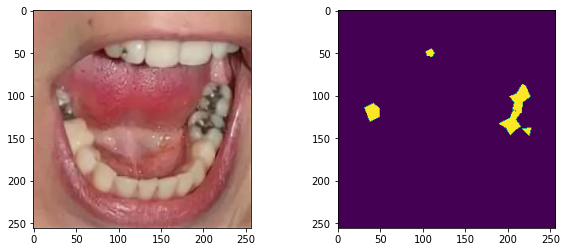

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].imshow(image)
ax[1].imshow(image2)

plt.show()

In [137]:
image2.max()

255.0

# Data Generator

In [274]:
def augment_image(image, mask):

    aug = A.Compose([
        
        A.RandomResizedCrop(64, 64, scale=(0.75, 1.0), p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        
        A.RandomRotate90(p=0.5),
        A.Rotate(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        
        # A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.03, alpha_affine=120 * 0.03),
        # A.GridDistortion(p=0.5),
        # A.OpticalDistortion(p=0.5, distort_limit=0.5, shift_limit=0.5),
        
        A.Blur(p=0.5),
        
        # A.CoarseDropout(p=0.5),
        
        # A.Downscale(p=0.5),
        
        A.GaussianBlur(p=0.5),
    
    ])

    augmented = aug(image=image, mask=mask)

    return augmented['image'], augmented['mask']

def crop_aug(image, mask):
    aug = A.Compose([
        A.RandomCrop(height=64, width=64, p=1),
    ])
    augmented = aug(image=image, mask=mask)
    return augmented['image'], augmented['mask']

In [275]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, paths, cs,
                 augment=True,
                 batch_size=16,
                 input_shape=256,
                 shuffle=True):
        
        self.paths = paths
        self.cs = cs
        self.augment = augment
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle
        self.n = len(self.paths)
        self.on_epoch_end()
        
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    
    def __load_data(self, paths, cs):
    
        X_batch = []
        y_batch = []
        
        for path, c in zip(paths, cs):
            
            counter = 0
            
            while True:
            
                X = cv2.cvtColor(cv2.imread(path).copy(), cv2.COLOR_BGR2RGB)
                
                y = cv2.drawContours(np.zeros((X.shape[0], X.shape[1])), c, -1, 1, -1)
                
                X, y = crop_aug(X, y)
                
                if y.sum() > 0:
                    if self.augment:
                        X, y = augment_image(X, y)
                    X_batch.append(X / 255.)
                    y_batch.append(y)
                    counter += 1
                else:
                    pass
                
                if counter == 8:
                    break
            
        return np.array(X_batch, dtype=float), np.array(y_batch, dtype=float)
    
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__load_data([self.paths[i] for i in indexes],
                                [self.cs[i] for i in indexes])
        return X, y
    
    
    def __len__(self):
        
        return int(np.floor(len(self.paths) / self.batch_size))

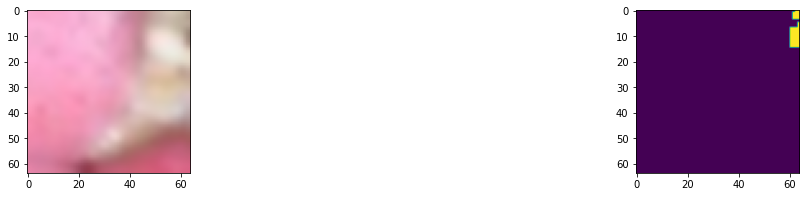

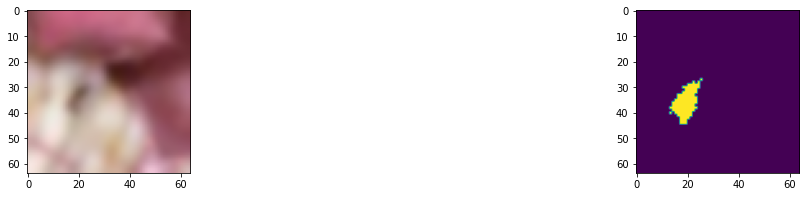

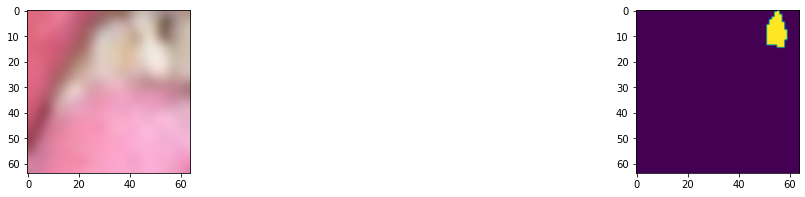

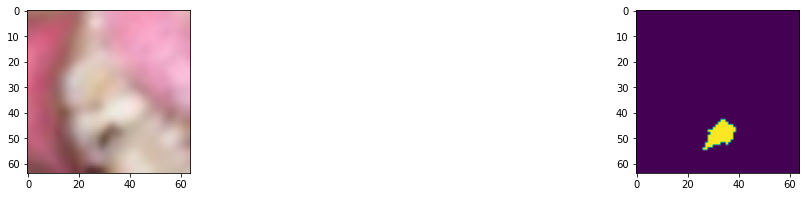

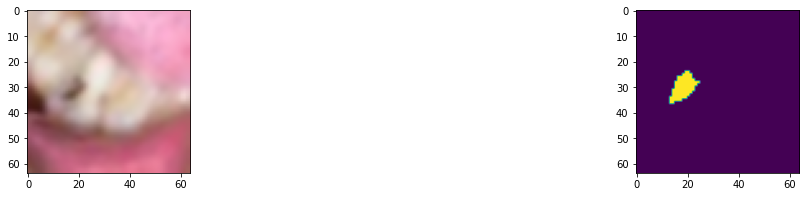

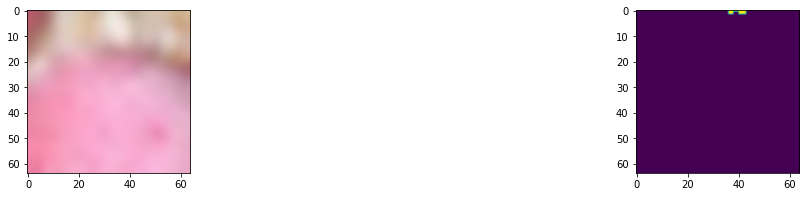

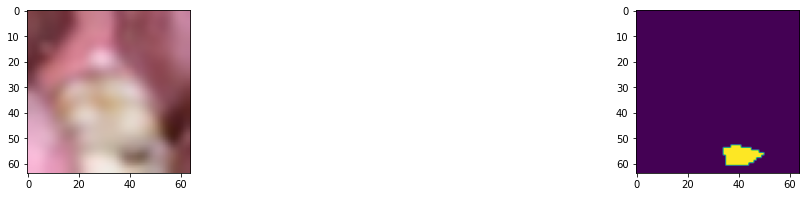

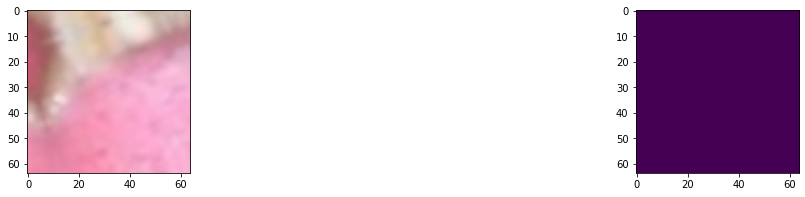

In [276]:
traingen = CustomDataGen(train_data.path, train_data.contour, 
                         input_shape=256, batch_size=1)

for x, y in traingen:
    break

i = 0
    
for xx, yy in zip(x, y):

    _, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax[0].imshow(xx)
    ax[1].imshow(yy)
    plt.show()

# Model

In [277]:
# def plot_preds(epoch, logs):
    
#     path = val_df.path.iloc[0]
#     c = val_df.contour.iloc[0]
    
#     X = cv2.cvtColor(cv2.imread(path).copy(), cv2.COLOR_BGR2RGB)
#     y = cv2.drawContours(np.zeros((X.shape[0], X.shape[1])), c, -1, 1, -1)
    
#     prediction = model.predict(X[np.newaxis, ...])[0, :, :, 0]
    
#     pred_thresh = prediction.copy()
#     pred_thresh[pred_thresh > 0.5] = 1
#     pred_thresh[pred_thresh <= 0.5] = 0
#     pred_thresh = pred_thresh.astype(int)
    
#     _, ax = plt.subplots(1, 4, figsize=(16, 4))
#     ax[0].imshow(X[:, :, 0])
#     ax[1].imshow(y)
#     ax[2].imshow(prediction)
#     ax[3].imshow(pred_thresh)
#     plt.suptitle(jaccard_score(y.flatten(), pred_thresh.flatten()))
#     plt.show()

In [278]:
def bce_jaccard_loss(y_true, y_pred, smooth=1):

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    
    return (1 - jac) * smooth + tf.keras.losses.binary_crossentropy(y_true, y_pred)

#Keras
ALPHA = 0.8
GAMMA = 2

def focal_bce_jaccard_loss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return bce_jaccard_loss(targets, inputs) + focal_loss

In [279]:
INP_SHAPE = 64
BATCH_SIZE = 8

In [280]:
K.clear_session()

model = sm.Unet('efficientnetb0', input_shape=(INP_SHAPE, INP_SHAPE, 3), 
                encoder_weights=None, weights=None)

# regularizer = tf.keras.regularizers.l2(0.001)
# for layer in model.layers:
#     for attr in ['kernel_regularizer']:
#         if hasattr(layer, attr):
#             setattr(layer, attr, regularizer)

metrics = [
    'mae',
    'accuracy'
]

model.compile(optimizer=Adam(), 
              loss=bce_jaccard_loss,
#               loss='binary_crossentropy', 
              metrics=metrics)

In [281]:
checkpoint_path = 'models/checkpoint_new/EfficientB0Unet_{}.h5'.format(INP_SHAPE)
# checkpoint_dir = os.path.dirname(checkpoint_path)
# if os.path.exists(checkpoint_dir):
#         shutil.rmtree(checkpoint_dir)
# os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(patience=30, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False),
    # LambdaCallback(on_epoch_end=plot_preds)
]

In [282]:
train_df, val_df = train_test_split(train_data, test_size=0.2)

train_datagen = CustomDataGen(list(train_df.path), list(train_df.contour), 
                              input_shape=INP_SHAPE, batch_size=BATCH_SIZE)
val_datagen = CustomDataGen(list(val_df.path), list(val_df.contour),  
                            input_shape=INP_SHAPE, 
                            batch_size=BATCH_SIZE, augment=False)

In [283]:
# plot_preds(0, 0)

In [284]:
results = model.fit(train_datagen, validation_data=val_datagen,
                    epochs=100, callbacks=callbacks)

Epoch 1/100


2022-06-25 23:06:56.578576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.4051 - mae: 0.3608 - accuracy: 0.8487

2022-06-25 23:07:07.616523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.58847, saving model to models/checkpoint_new/EfficientB0Unet_64.h5
4/4 [==============================] - 21s 2s/step - loss: 1.4051 - mae: 0.3608 - accuracy: 0.8487 - val_loss: 1.5885 - val_mae: 0.4820 - val_accuracy: 0.9477 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 1.2694 - mae: 0.2822 - accuracy: 0.9464
Epoch 2: val_loss improved from 1.58847 to 1.56066, saving model to models/checkpoint_new/EfficientB0Unet_64.h5
4/4 [==============================] - 5s 1s/step - loss: 1.2694 - mae: 0.2822 - accuracy: 0.9464 - val_loss: 1.5607 - val_mae: 0.4718 - val_accuracy: 0.9362 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 1.1914 - mae: 0.2314 - accuracy: 0.9599
Epoch 3: val_loss improved from 1.56066 to 1.53683, saving model to models/checkpoint_new/EfficientB0Unet_64.h5
4/4 [==============================] - 4s 1s/step - loss: 1.1914 - mae: 0.2314 - accuracy: 0.9599 - val_loss: 

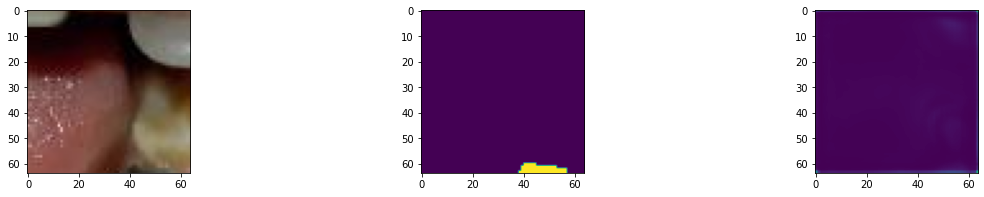

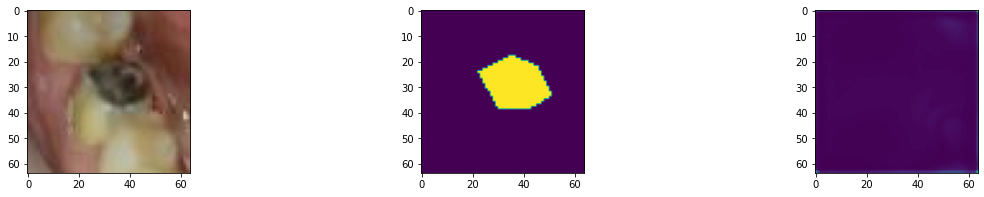

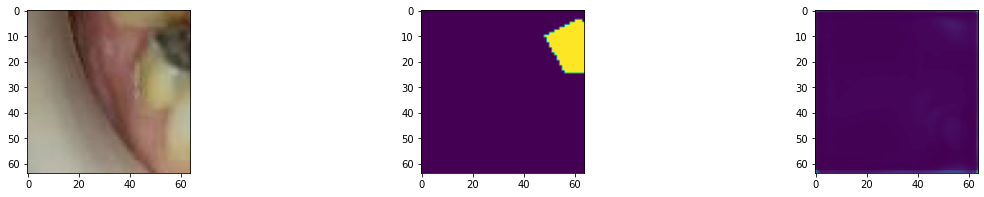

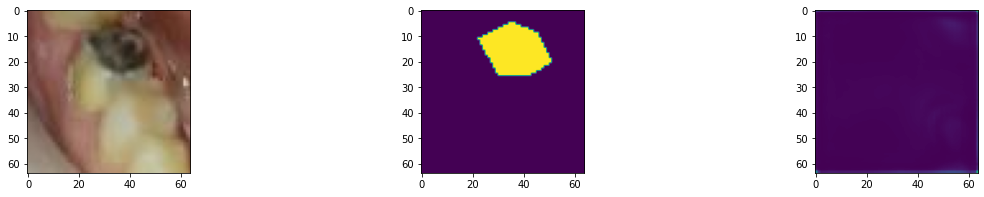

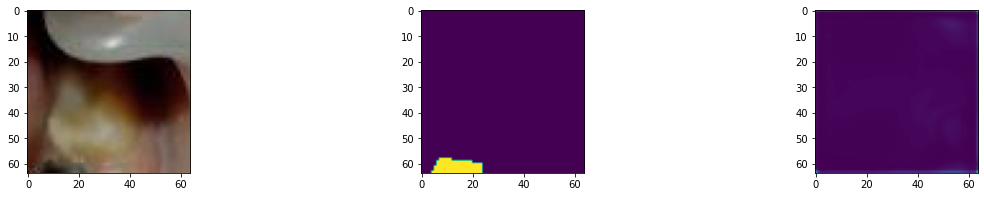

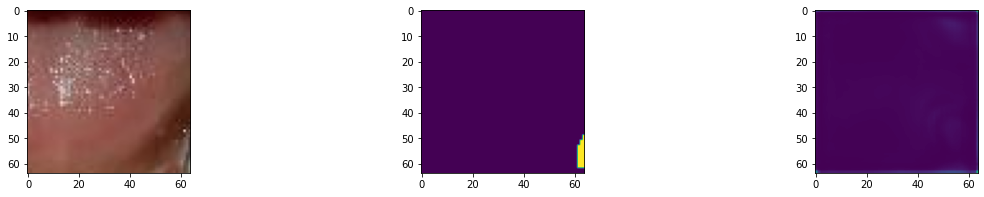

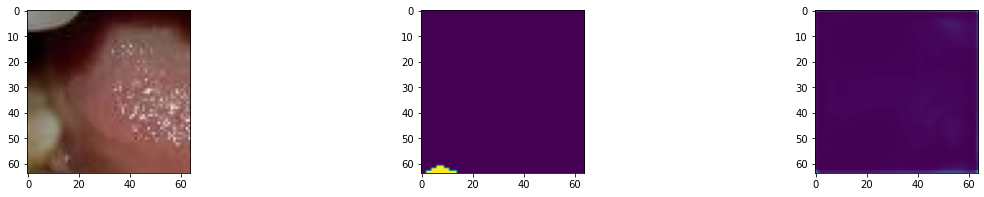

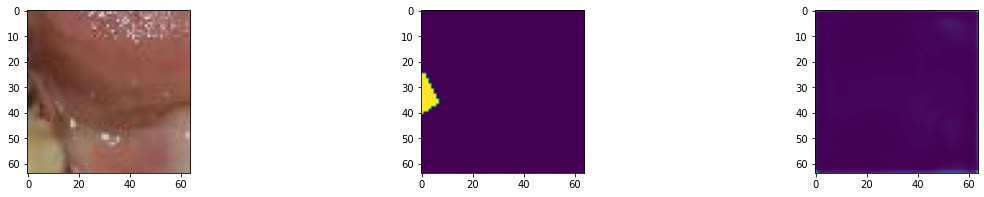

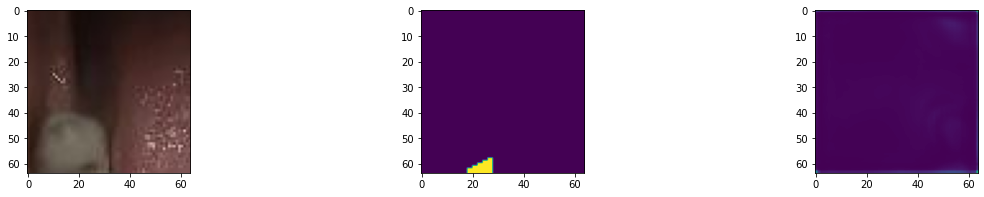

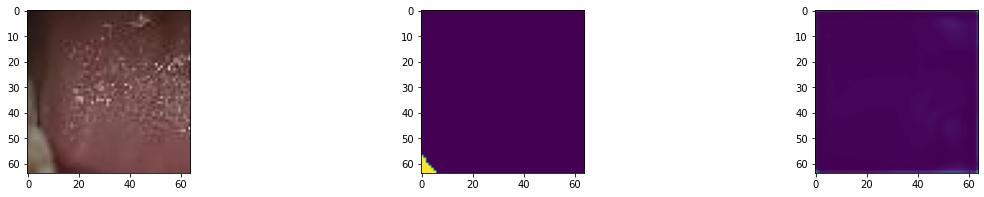

In [287]:
for x, y in val_datagen:
    break

i = 0

preds = model.predict(x)
    
for xx, yy in zip(x[:10], y[:10]):

    _, ax = plt.subplots(1, 3, figsize=(20, 3))
    ax[0].imshow(xx)
    ax[1].imshow(yy)
    ax[2].imshow(preds[i])
    plt.show()